In [1]:
import warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

data = sm.datasets.co2.load_pandas()
y = data.data

# 这里以 月为周期
y = y['co2'].resample('MS').mean()

# 缺失值填充
y = y.fillna(y.bfill())

print(y)

1958-03-01    316.100000
1958-04-01    317.200000
1958-05-01    317.433333
1958-06-01    315.625000
1958-07-01    315.625000
                 ...    
2001-08-01    369.425000
2001-09-01    367.880000
2001-10-01    368.050000
2001-11-01    369.375000
2001-12-01    371.020000
Freq: MS, Name: co2, Length: 526, dtype: float64


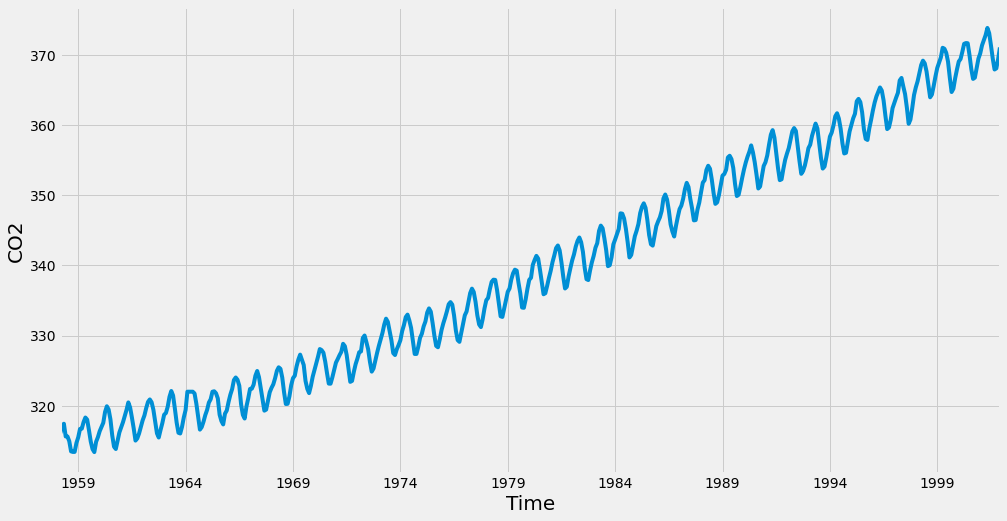

In [2]:
y.plot(figsize=(15, 8))
plt.xlabel('Time', fontsize = 20)
plt.ylabel('CO2', fontsize = 20)
plt.show()

In [3]:
#补充知识：检验时间序列平稳性
#方法一：绘制移动平均值和标准差

def TestStationaryPlot(df):
    rol_mean = df.rolling(window = 12, center = False).mean()
    rol_std = df.rolling(window = 12, center = False).std()
    
    #plt.plot(figsize=(15, 8))
    plt.plot(df, color = 'blue',label = 'Original')
    plt.plot(rol_mean, color = 'red', linestyle='-.', label = 'Moving Average')
    plt.plot(rol_std, color ='black', linestyle='--', label = 'Standard Deviation')
    plt.xticks(fontsize = 16)
    plt.yticks(fontsize = 16)

    plt.xlabel('Time', fontsize = 16)
    plt.ylabel('CO2', fontsize = 16)
    plt.legend(loc='best', fontsize = 16)
    plt.title('Moving Average and Standard Deviation', fontsize = 22)
    plt.show(block= True)

In [4]:
#方法二：ADF检验
from statsmodels.tsa.stattools import adfuller

def TestStationaryAdfuller(df, cutoff = 0.01):
    df_test = adfuller(df, autolag = 'AIC')
    df_test_output = pd.Series(df_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

    for key,value in df_test[4].items():
        df_test_output['Critical Value (%s)'%key] = value
    print(df_test_output)

    if df_test[1] <= cutoff:
        print('拒绝原假设，即数据没有单位根,序列是平稳的。')
    else:
        print('不能拒绝原假设，即数据存在单位根,数据是非平稳序列。')

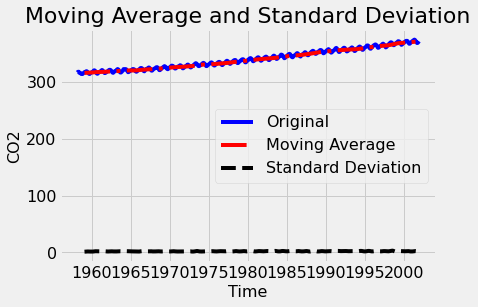

Test Statistic                   2.359810
p-value                          0.998990
#Lags Used                      14.000000
Number of Observations Used    511.000000
Critical Value (1%)             -3.443212
Critical Value (5%)             -2.867213
Critical Value (10%)            -2.569791
dtype: float64
不能拒绝原假设，即数据存在单位根,数据是非平稳序列。


In [5]:
#对CO2进行平稳性检验

TestStationaryPlot(y)
TestStationaryAdfuller(y)

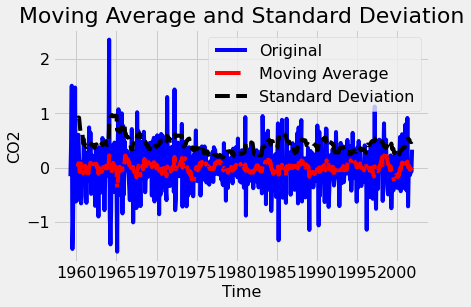

Test Statistic                -8.724892e+00
p-value                        3.308994e-14
#Lags Used                     1.500000e+01
Number of Observations Used    4.970000e+02
Critical Value (1%)           -3.443576e+00
Critical Value (5%)           -2.867373e+00
Critical Value (10%)          -2.569877e+00
dtype: float64
拒绝原假设，即数据没有单位根,序列是平稳的。


In [6]:
#原始序列进行平稳化
from statsmodels.graphics.tsaplots import acf,pacf,plot_acf,plot_pacf
from statsmodels.graphics.api import qqplot

#对原始序列做一阶12步差分
y_diff = y.diff(1)
y_seasonal_diff = y_diff - y_diff.shift(12)
TestStationaryPlot(y_seasonal_diff.dropna(inplace=False))
TestStationaryAdfuller(y_seasonal_diff.dropna(inplace=False))

#差分后序列的时序图可以发现，移动平均值在0值上下波动，且方差随着时间的变化波动也非常小，这说明差分后的序列类似平稳。

#ADF检验可知，检验统计量的值为-8.724892，在90%、95%和99%的置信度下，检验统计量的值均小于对应的临界值。
#所以，有充分的证据可以拒绝原假设，认为1阶12步差分后的序列是平稳的。

In [8]:
#再对1阶12步差分后序列做白噪声检验
warnings.filterwarnings('ignore') 


y_seasonal_diff.dropna(inplace = True)
r,q,p = sm.tsa.acf(y_seasonal_diff.values.squeeze(), qstat=True) 
data = np.c_[range(1,41), r[1:], q, p] 
table = pd.DataFrame(data, columns=['lag', 'AC', 'Q', 'Prob(>Q)']) 
print(table.set_index('lag'))

#从白噪声结果来看，Q统计量的P值均小于0.01，所以在0.01的显著性水平下，拒绝原假设，即1阶12步差分后的序列是非白噪声序列。

            AC           Q      Prob(>Q)
lag                                     
1.0  -0.255840   33.774780  6.187583e-09
2.0  -0.047118   34.922607  2.610070e-08
3.0  -0.103074   40.426243  8.653556e-09
4.0   0.013590   40.522098  3.375382e-08
5.0   0.028528   40.945355  9.624324e-08
6.0  -0.000195   40.945375  2.968305e-07
7.0  -0.023980   41.245617  7.262672e-07
8.0   0.012222   41.323759  1.813216e-06
9.0   0.071615   44.012245  1.404118e-06
10.0  0.033937   44.617167  2.549247e-06
11.0  0.110923   51.092486  3.978430e-07
12.0 -0.415004  141.914522  2.458708e-24
13.0  0.071497  144.615592  2.496098e-24
14.0  0.042874  145.588835  5.468074e-24
15.0  0.010188  145.643905  1.763535e-23
16.0 -0.066838  148.018617  1.919709e-23
17.0  0.008715  148.059073  5.866823e-23
18.0  0.022009  148.317619  1.576984e-22
19.0  0.031151  148.836573  3.673377e-22
20.0 -0.055619  150.494349  5.054499e-22
21.0  0.011627  150.566941  1.370175e-21
22.0 -0.079657  153.981146  8.462916e-22
23.0  0.038307  

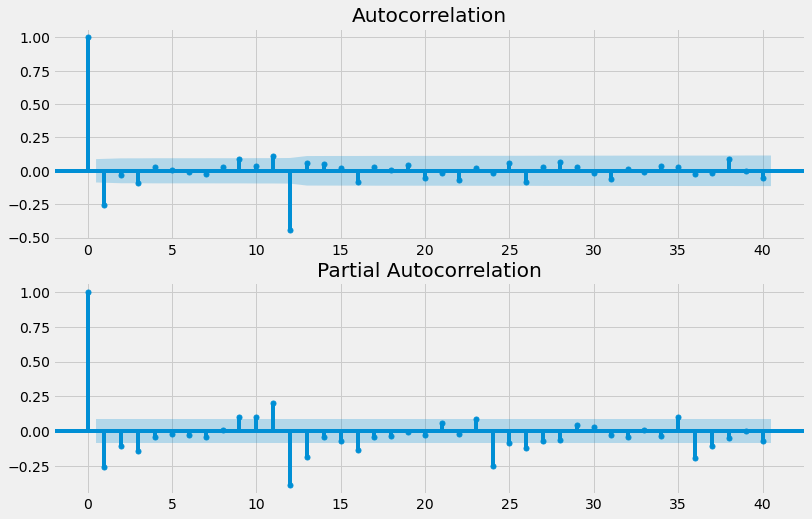

In [9]:
#方法一：通过ACF和PACF图来确定模型参数值

#ACF和 PACF图
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(y_seasonal_diff.iloc[13:], lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(y_seasonal_diff.iloc[13:], lags=40, ax=ax2)
plt.show()

In [10]:
#方法二：网格搜索

# 首先定义 p、d、q 的参数值范围，这里取 0 - 2.
p = d = q = range(0, 2)

# 然后用itertools生成不同的参数组合
pdq = list(itertools.product(p, d, q))

# 同理处理季节周期性参数，也生成相应的多个组合
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [11]:
warnings.filterwarnings('ignore') 

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('SARIMAX{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

SARIMAX(0, 0, 0)x(0, 0, 0, 12)12 - AIC:7612.583429881011
SARIMAX(0, 0, 0)x(0, 0, 1, 12)12 - AIC:6787.343624041359
SARIMAX(0, 0, 0)x(0, 1, 0, 12)12 - AIC:1854.8282341411875
SARIMAX(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1596.7111727639399
SARIMAX(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1058.9388921320035
SARIMAX(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1056.2878491938754
SARIMAX(0, 0, 0)x(1, 1, 0, 12)12 - AIC:1361.657897806414
SARIMAX(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1044.764791297198
SARIMAX(0, 0, 1)x(0, 0, 0, 12)12 - AIC:6881.048755202302
SARIMAX(0, 0, 1)x(0, 0, 1, 12)12 - AIC:6072.662327748383
SARIMAX(0, 0, 1)x(0, 1, 0, 12)12 - AIC:1379.1941067016137
SARIMAX(0, 0, 1)x(0, 1, 1, 12)12 - AIC:1241.4174716797215
SARIMAX(0, 0, 1)x(1, 0, 0, 12)12 - AIC:1093.8473394075631
SARIMAX(0, 0, 1)x(1, 0, 1, 12)12 - AIC:780.431587989397
SARIMAX(0, 0, 1)x(1, 1, 0, 12)12 - AIC:1119.5957893601012
SARIMAX(0, 0, 1)x(1, 1, 1, 12)12 - AIC:807.0912988275331
SARIMAX(0, 1, 0)x(0, 0, 0, 12)12 - AIC:1675.8086923024293
SARIMAX(0, 1, 0)x(0, 0,

In [12]:
#从上图可以看出最优参数组合：ARIMA(1, 1, 1)x(1, 1, 1, 12)12 因为对应的AIC:277.78022407978824 是最小的。
#模型的拟合

mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3181      0.092      3.441      0.001       0.137       0.499
ma.L1         -0.6254      0.077     -8.162      0.000      -0.776      -0.475
ar.S.L12       0.0010      0.001      1.732      0.083      -0.000       0.002
ma.S.L12      -0.8769      0.026    -33.806      0.000      -0.928      -0.826
sigma2         0.0972      0.004     22.632      0.000       0.089       0.106


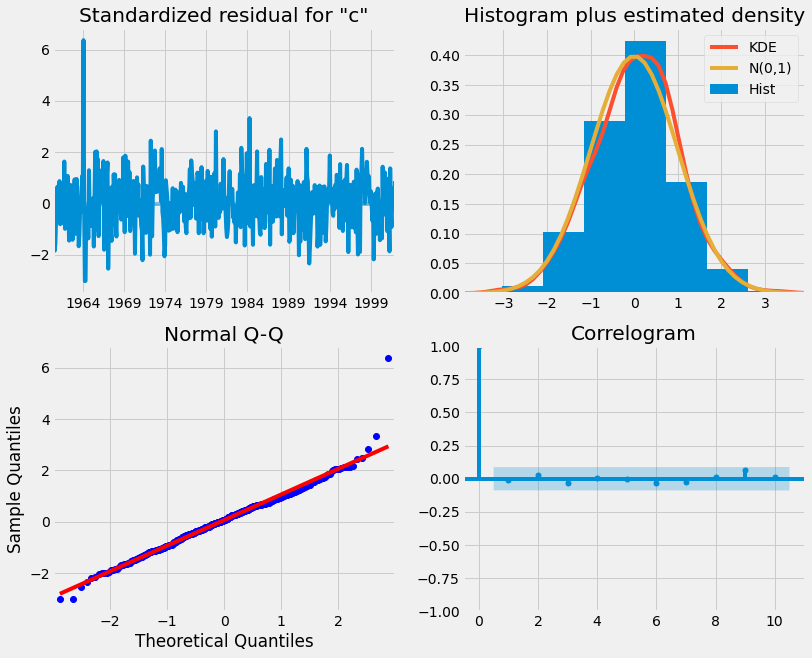

In [13]:
#模型的验证
results.plot_diagnostics(figsize=(12, 10))
plt.show()

In [14]:
#残差的白噪声检验

r,q,p = sm.tsa.acf(results.resid.values.squeeze(), qstat=True) 
data = np.c_[range(1,41), r[1:], q, p] 
table = pd.DataFrame(data, columns=['lag', 'AC', 'Q', 'Prob(>Q)']) 
print(table.set_index('lag'))

            AC           Q      Prob(>Q)
lag                                     
1.0  -0.127836    8.645055  3.279503e-03
2.0  -0.010964    8.708765  1.285037e-02
3.0  -0.009787    8.759627  3.266353e-02
4.0   0.003028    8.764504  6.726299e-02
5.0   0.000264    8.764541  1.188325e-01
6.0  -0.001447    8.765660  1.871924e-01
7.0   0.002048    8.767903  2.697520e-01
8.0  -0.002713    8.771850  3.619067e-01
9.0   0.007718    8.803845  4.555747e-01
10.0  0.007562    8.834621  5.478674e-01
11.0  0.048442   10.100128  5.214037e-01
12.0 -0.461229  125.045076  6.072601e-21
13.0  0.086712  129.115704  3.136119e-21
14.0  0.000318  129.115759  1.015930e-20
15.0  0.003209  129.121355  3.159317e-20
16.0 -0.003377  129.127566  9.478823e-20
17.0 -0.001149  129.128285  2.757761e-19
18.0  0.001691  129.129848  7.774428e-19
19.0 -0.000833  129.130228  2.129483e-18
20.0  0.003645  129.137519  5.656661e-18
21.0 -0.001903  129.139511  1.467113e-17
22.0  0.000324  129.139569  3.714577e-17
23.0 -0.001320  

In [15]:
#模型的预测
#预测检验

pred = results.get_prediction(start=pd.to_datetime('1998-01-01'), dynamic=False)
pred_ci = pred.conf_int()

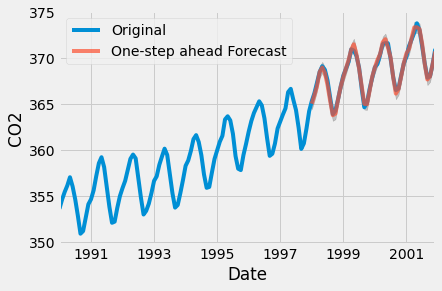

In [16]:
#画出预测值和真实值的plot图

ax = y['1990':].plot(label='Original')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('CO2')
plt.legend()

plt.show()

In [17]:
#计算MSE和RMSE
y_forecasted = pred.predicted_mean
y_truth = y['1998-01-01':]

mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of forecasts is {}'.format(np.sqrt(sum((y_forecasted-y_truth)**2)/len(y_forecasted))))

The Mean Squared Error of forecasts is 0.07
The Root Mean Squared Error of forecasts is 0.27019448298898624


In [18]:
#再次验证

pred2 = results.get_prediction(start=pd.to_datetime('1998-01-01'), dynamic = True, full_results=True)
pred_ci2 = pred2.conf_int()

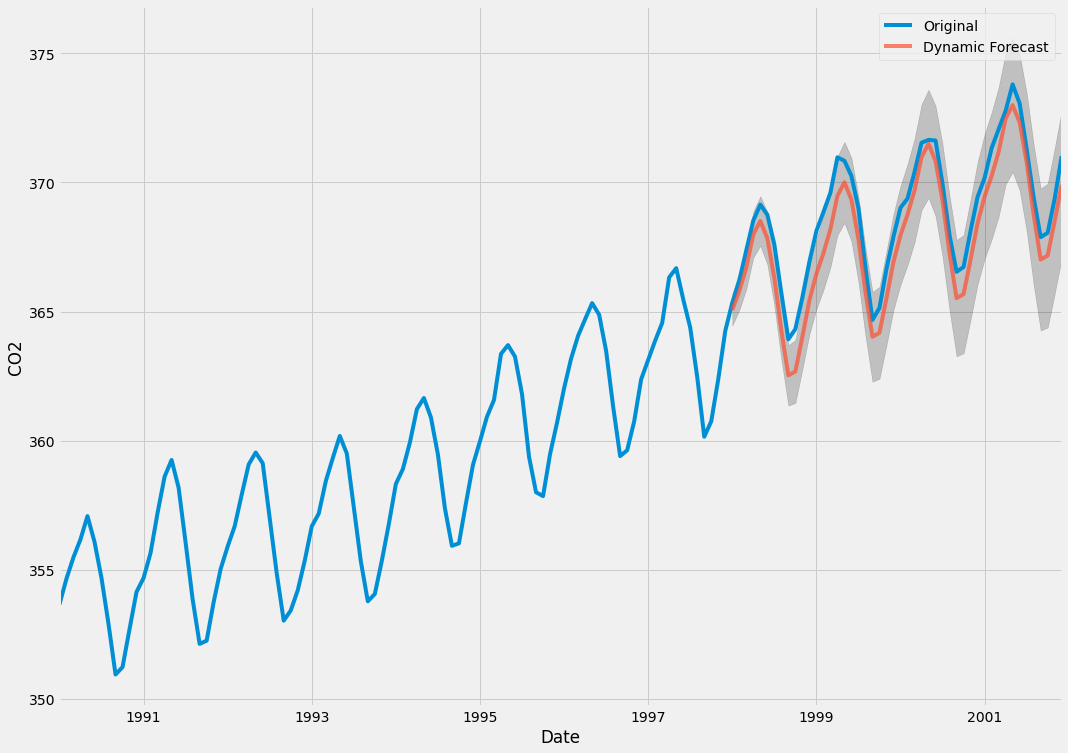

In [19]:
ax = y['1990':].plot(label='Original', figsize=(16, 12))
pred2.predicted_mean.plot(ax=ax, label='Dynamic Forecast', alpha=.7)

ax.fill_between(pred_ci2.index,
                pred_ci2.iloc[:, 0],
                pred_ci2.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('CO2')
plt.legend()

plt.show()

In [20]:
y_forecasted2 = pred2.predicted_mean
y_truth2 = y['1998-01-01':]

mse = ((y_forecasted2 - y_truth2) ** 2).mean()
print('The Mean Squared Error of forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of forecasts is {}'.format(np.sqrt(sum((y_forecasted2-y_truth2)**2)/len(y_forecasted2))))

The Mean Squared Error of forecasts is 1.01
The Root Mean Squared Error of forecasts is 1.0047872760305145


In [21]:
#最后一步，预测
#预测未来的10年的数据
pred_fc = results.get_forecast(steps = 120)

# 预测置信区间
pred_ci = pred_fc.conf_int()

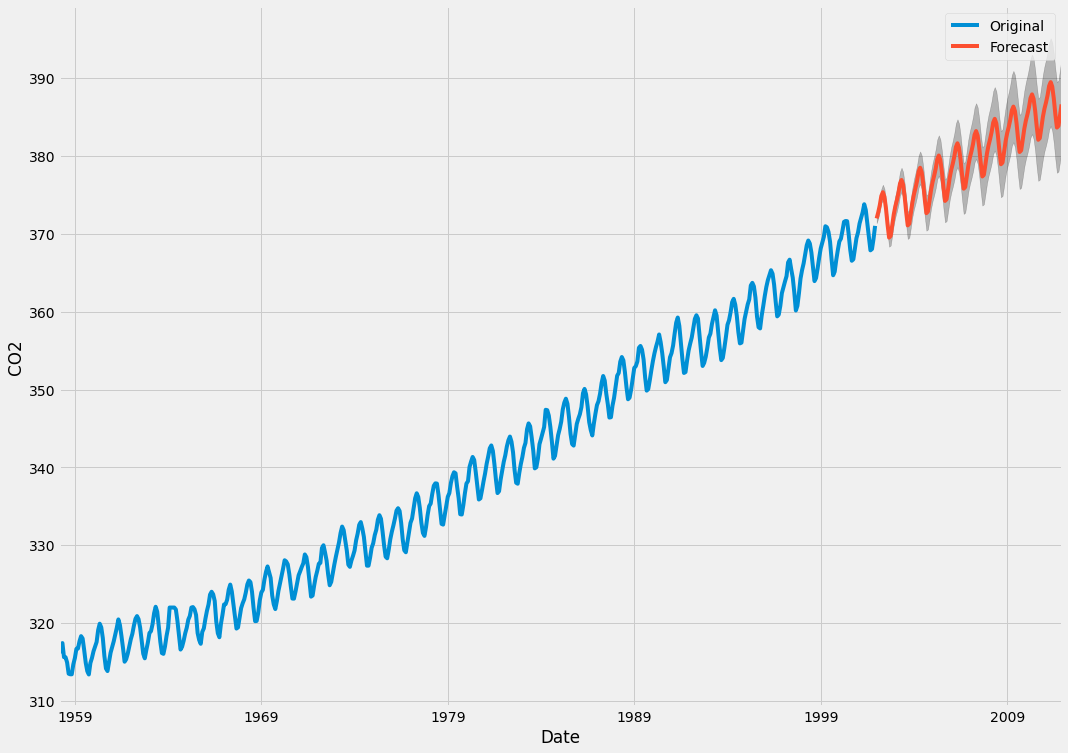

In [22]:
ax = y.plot(label='Original', figsize=(16, 12))
pred_fc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('CO2')

plt.legend()
plt.show()

In [23]:
#生成未来10年的预测值
pre_fc = pred_fc.predicted_mean
pre_fc

2002-01-01    371.977655
2002-02-01    372.749101
2002-03-01    373.662309
2002-04-01    374.859617
2002-05-01    375.345749
                 ...    
2011-08-01    385.359160
2011-09-01    383.648772
2011-10-01    383.857146
2011-11-01    385.208961
2011-12-01    386.617936
Freq: MS, Name: predicted_mean, Length: 120, dtype: float64